# ENRON Person of Interest Identifier
by Fernando Maletski

## Introduction

The famous ENRON scandal was the largest bankruptcy reorganization in the United States at the time it was publicized, October 2001. Due to the Federal investigation, a significant amount of confidential information was released to the public, including tens of thousands of emails and detailed financial data.

The objective of this project is to use this large dataset to create a machine learning model that correctly identifiers the Persons of Interest (POI) based on the data made public.

## Workspace Setup

In [1]:
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib
import operator
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot') #Set a decent style
matplotlib.rcParams['image.cmap'] = 'bwr' #Diverging colors

with open("final_project_dataset_py3.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

## EDA, Feature Engineering and Selection

In this section we will explore the dataset, explain features and clean issues, such as missing values and outliers.

In [2]:
len(sorted(data_dict.keys()))

146

There are 146 datapoints, but one of them is an outlier, called "TOTAL", let's remove it:

In [3]:
data_dict.pop('TOTAL')

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [4]:
len(sorted(data_dict.keys()))

145

There are 145 datapoints, each of them represents a person whose records were made public, the key of this dictionary is their name in this format: LAST NAME FIRST NAME (MIDDLE INICIAL):

In [5]:
persons = sorted(data_dict.keys())
persons[0:10]

['ALLEN PHILLIP K',
 'BADUM JAMES P',
 'BANNANTINE JAMES M',
 'BAXTER JOHN C',
 'BAY FRANKLIN R',
 'BAZELIDES PHILIP J',
 'BECK SALLY W',
 'BELDEN TIMOTHY N',
 'BELFER ROBERT',
 'BERBERIAN DAVID']

The values of the dictionary are another dictionary that follows this schema (key: value): feature: value.
Extracting the list of features:

In [6]:
feature_list = sorted(data_dict['ALLEN PHILLIP K'])
print(len(feature_list))
feature_list

21


['bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'email_address',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']

Testing to see if all the datapoints have the same features:

In [7]:
count = 0
for person, data in data_dict.items():
    for feature, value in data.items():
        if feature not in feature_list:
            print(person, feature)
        else:
            count += 1
total_count = len(feature_list) * len(data_dict.keys())
print('{} of {} found'.format(count, total_count))

3045 of 3045 found


This is all the features of the dataset, the structure supports a table schema. So it's possible to convert this dataset to an exploration friendly format, a pandas DataFrame:

In [8]:
df = pd.DataFrame(data_dict)
df = df.transpose()
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


Replacing 'NaN' string with np.NaN for compatibility with numeric methods:

In [9]:
df.replace('NaN', np.NaN, inplace=True)

Here's a print from a random person to have an idea of the information from each datapoint:

In [10]:
df.iloc[12]

bonus                                          1e+06
deferral_payments                                NaN
deferred_income                                  NaN
director_fees                                    NaN
email_address                philippe.bibi@enron.com
exercised_stock_options                  1.46573e+06
expenses                                       38559
from_messages                                     40
from_poi_to_this_person                           23
from_this_person_to_poi                            8
loan_advances                                    NaN
long_term_incentive                           369721
other                                         425688
poi                                            False
restricted_stock                              378082
restricted_stock_deferred                        NaN
salary                                        213625
shared_receipt_with_poi                         1336
to_messages                                   

An overview:

In [11]:
total_dps = len(df)
poi_dps = df.poi.sum()
print('Total Data Points: {:>3}'.format(total_dps))
print('Total POI        : {:>3}'.format(poi_dps))

Total Data Points: 145
Total POI        :  18


There is 2 classes of features, finance related and email related:

* **financial features:** ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

* **email features:** ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

In [12]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                      'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock',
                      'director_fees']

email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 
                     'from_this_person_to_poi', 'shared_receipt_with_poi']

### Email Features

In [13]:
print(email_features)

['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


The first approach we can take is to see if POIs communicate to each other a lot, using the features from_poi_to_this_person and from_this_person_to_poi:

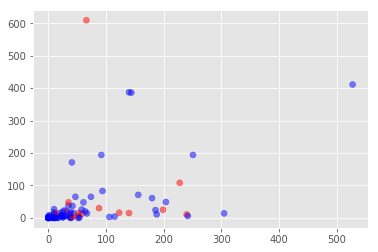

In [14]:
plt.scatter(df.from_poi_to_this_person, df.from_this_person_to_poi, c=df.poi, alpha=0.5)

It is a good idea, but there are people who sends a lot of emails and those that don't, so, engineering 2 new features, from_poi_ratio and to_poi_ratio may help:

In [15]:
df['from_poi_ratio'] = df.from_poi_to_this_person/df.to_messages
df['to_poi_ratio'] = df.from_this_person_to_poi/df.from_messages

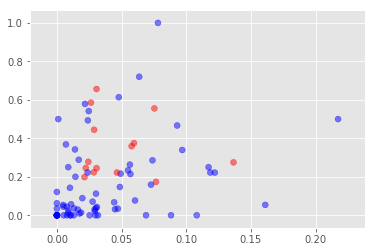

In [16]:
plt.scatter(df.from_poi_ratio, df.to_poi_ratio, c=df.poi, alpha=0.5)

Good, these features will help to filter a lot of people.

Using the same line of thought with the feature "shared_receipt_with_poi" doesn't help too much:

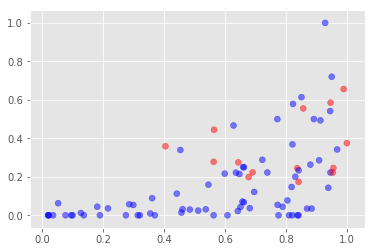

In [17]:
plt.scatter(df.shared_receipt_with_poi/df.to_messages, df.to_poi_ratio, c=df.poi, alpha=0.5)

In [18]:
selected_email_features = ['from_poi_ratio', 'to_poi_ratio']

### Financial Features

There is a lot of financial features:

In [19]:
print(financial_features)
print(len(financial_features))

['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
14


#### Missing Values

If there is features with too much missing values, they won't help with the classification.

In [20]:
print_list = []
for feature in financial_features:
    title = feature
    count = df[feature].count()
    missing = total_dps - count
    poi_count = len(df.query(feature+' != "NaN" and poi==True'))
    pct_missing = 100*missing/total_dps
    print_list.append((title, count, missing, poi_count, pct_missing))

print('{:>30}: {:<8} {:<8} {:<10} {:<8}'.format('Title', 'Count', 'Missing', 'POI Count', '% Missing'))
for (title, count, missing, poi_count, pct_missing) in sorted(print_list, key=operator.itemgetter(4),
                                                              reverse=True):
    print('{:>30}: {:<8} {:<8} {:<10} {:<8.2f}'.format(title, count, missing, poi_count, pct_missing))

                         Title: Count    Missing  POI Count  % Missing
                 loan_advances: 3        142      1          97.93   
                 director_fees: 16       129      0          88.97   
     restricted_stock_deferred: 17       128      0          88.28   
             deferral_payments: 38       107      5          73.79   
               deferred_income: 48       97       11         66.90   
           long_term_incentive: 65       80       12         55.17   
                         bonus: 81       64       16         44.14   
                         other: 92       53       18         36.55   
                        salary: 94       51       17         35.17   
                      expenses: 94       51       18         35.17   
       exercised_stock_options: 101      44       12         30.34   
              restricted_stock: 109      36       17         24.83   
                total_payments: 124      21       18         14.48   
             total_

Features with a high amount of missing values and low POI count won't be useful. Removing them:

In [21]:
features_to_remove = ['loan_advances', 'director_fees', 'restricted_stock_deferred', 
                      'deferral_payments']
for feature in features_to_remove:
    financial_features.remove(feature)
print(financial_features)
len(financial_features)

['salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock']


10

#### Exploration

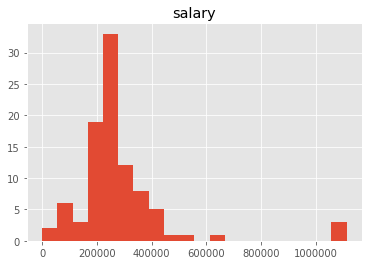

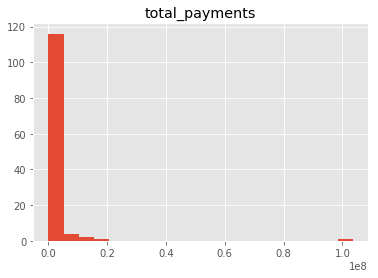

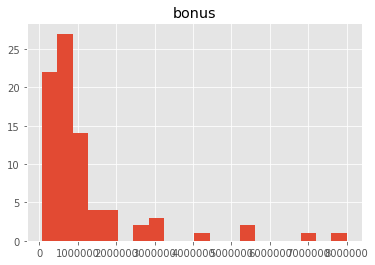

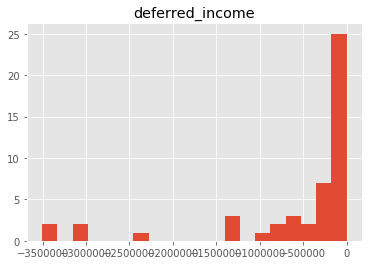

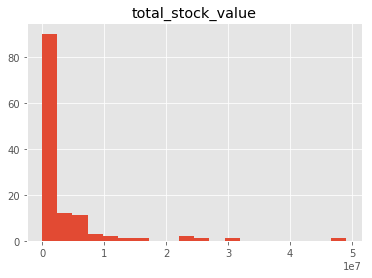

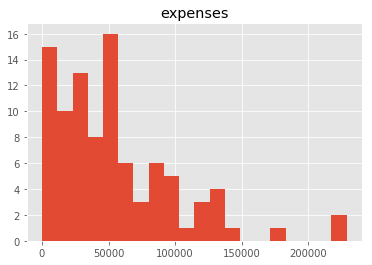

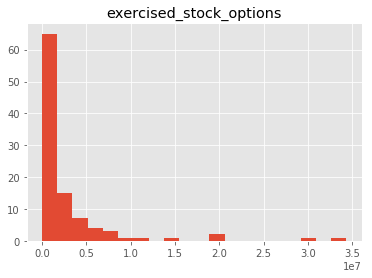

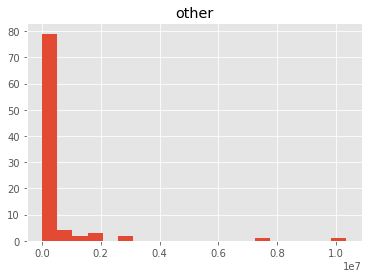

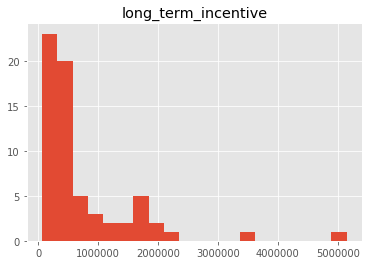

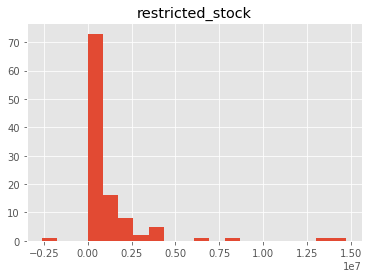

In [22]:
for feature in financial_features:
    plt.hist(df[feature].dropna(),20)
    plt.title(feature)
    plt.show()

With the exception of salary, all features are skewed. Using it as a basis for scatterplots to have an idea of the POI/non-POI distribution:

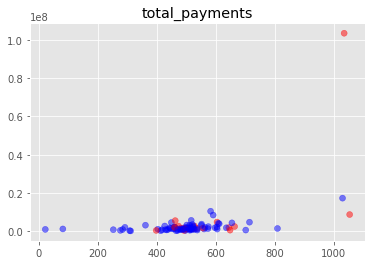

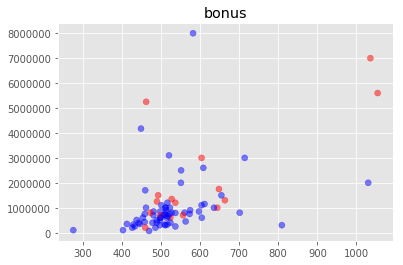

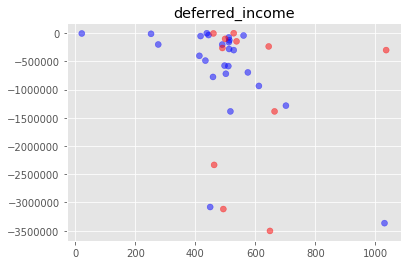

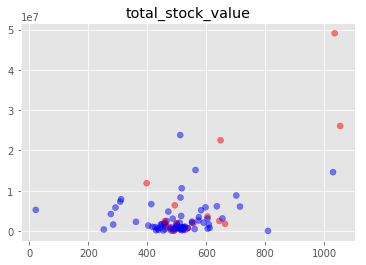

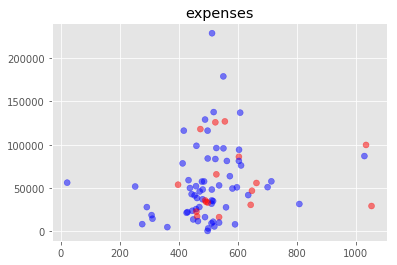

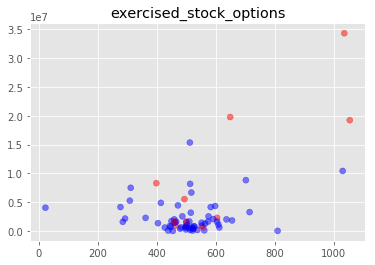

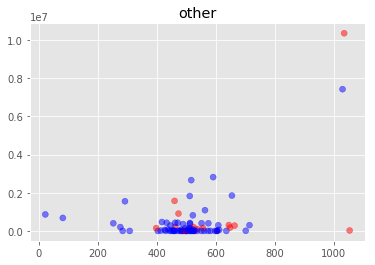

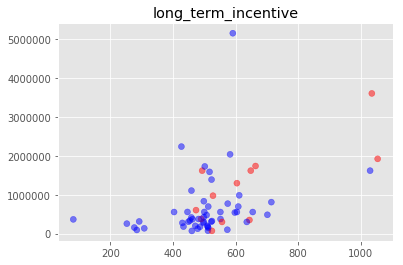

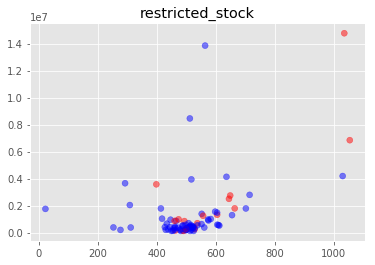

In [23]:
for feature in financial_features[1:]:
    plt.scatter(np.sqrt(df.salary), df[feature], c=df.poi, alpha=0.5)
    plt.title(feature)
    plt.show()

### Feature Selection

In [118]:
features = selected_email_features+financial_features
print(features)
len(features)

['from_poi_ratio', 'to_poi_ratio', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock']


12

While exploring and selecting them by hand is a valid approach, so is using statistics to do it. 

This code will print the p_values and ANOVA F-scores of each feature (NaN is filled with 0):

FORMAT: p_value : feature : F-score

In [119]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest()
selector.fit(df[features].fillna(0), df.poi)

SelectKBest(k=10, score_func=<function f_classif at 0x7f60880c6048>)

In [121]:
print('{:>30} :{:^30}: {}'.format('p_value', 'Feature', 'F-score'))
print('')
for (feature, score, pvalue) in sorted(zip(features, selector.scores_, selector.pvalues_),
                               key=operator.itemgetter(1), reverse=True):
    print('{:>30} :{:^30}: {}'.format(pvalue, feature, score))

                       p_value :           Feature            : F-score

         1.398443796240722e-06 :   exercised_stock_options    : 25.3801052997602
         1.844426415180382e-06 :      total_stock_value       : 24.752523020258508
         8.548240899761827e-06 :            bonus             : 21.3278904139791
        2.6464485993698053e-05 :            salary            : 18.861795316466416
          6.69501897034152e-05 :         to_poi_ratio         : 16.873870264572993
         0.0008017876244783438 :       deferred_income        : 11.732698076065354
           0.00170779873759263 :     long_term_incentive      : 10.222904205832778
          0.002490134850136291 :       restricted_stock       : 9.480743203478934
          0.003239087410989142 :        total_payments        : 8.96781934767762
          0.012667743910203918 :           expenses           : 6.3746144901977475
           0.04074414136894844 :            other             : 4.263576638144469
            0.07163635

k for different alphas:

* 0.05 : k = 11
* 0.01 : k = 9
* 0.001: k = 6

Using k = 6 (pvalue < 0.001):

In [27]:
selector = SelectKBest(k=6)
filtered = selector.fit_transform(df[features].fillna(0), df.poi)
selected_features = []
for (feature, selected) in zip(features, selector.get_support()):
    if selected:
        selected_features.append(feature)

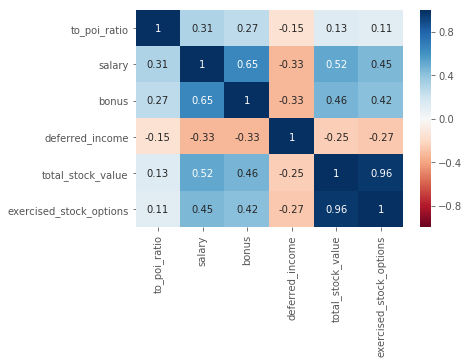

In [28]:
selected = pd.DataFrame(filtered, columns = selected_features)
corr = selected.corr()
sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns, cmap='RdBu', 
            vmin = -1.0, vmax = 1.0, annot = True)

## Model Selection

As per http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html, the workflow should be:

* Linear SVC
* KN Classifier
* SVC (other kernels)
* Ensemble Classifiers
    + Random Forest
    + Adaboost

In [29]:
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#### Prepare the dataset

First of all, it's necessary to convert the data to np.ndarray, pandas does not work well with sklearn. The main issue I've found, is that the MinMaxScaler.fit and SVC.fit run forever using Jupyter, consuming processing power but not delivering the results, the same problem is not found using standalone modules.

**Note.** It may be a good idea to file a bug report.

In [31]:
features = df[selected_features].fillna(0).values
labels = df.poi.values

Scaling the features helps with overall classification performance.

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

#### Evaluation Metrics

The dataset is very unbalanced towards non-POI:

In [33]:
print('POI: {} | Total: {}'.format(np.sum(labels), len(labels)))

POI: 18 | Total: 145


Using precision, or F1, generates warnings because a lot of the times they end up dividing by 0. Ignoring warnings:

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
print('Accuracy if predicted all non-POI: {:0.6f}'.format((145-18)/145))

Accuracy if predicted all non-POI: 0.875862


Ideally, the classifier should be more accurate than 0.8759, while having high recall and precision.

Due to the imbalanced nature of the dataset (way more non-POI than POI), using just accuracy, or even F1, results in poor detection performance.

The objective here is fraud detection! A model that is accurate but doesn't detect a lot of POI is not a good one.

There is a metric specifically created to deal with highly imbalanced classes, called Matthews correlation coefficient:

The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.[source: Wikipedia | http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html | https://en.wikipedia.org/wiki/Matthews_correlation_coefficient]

The MCC is the chosen metric in this project for parameter tuning and evaluation.

Preparing the metrics for iteration using GridSearchCV:

In [37]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
mcc = make_scorer(matthews_corrcoef)
scorers = {'mcc': mcc, 'accuracy': 'accuracy', 'f1': 'f1', 
           'recall': 'recall', 'precision': 'precision'}

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
def print_summary(clf):
    print(clf.best_estimator_)
    mcc = clf.cv_results_['mean_test_mcc'][clf.best_index_]
    print('MCC:       {:0.4f}'.format(mcc))
    f1 =  clf.cv_results_['mean_test_f1'][clf.best_index_]
    print('F1:        {:0.4f}'.format(f1))
    pre = clf.cv_results_['mean_test_precision'][clf.best_index_]
    print('Precision: {:0.4f}'.format(pre))
    rec = clf.cv_results_['mean_test_recall'][clf.best_index_]
    print('Recall:    {:0.4f}'.format(rec))
    acc = clf.cv_results_['mean_test_accuracy'][clf.best_index_]
    print('Accuracy:  {:0.4f}'.format(acc))
    return (str(clf.best_estimator_).split('(')[0], mcc, f1, pre, rec, acc)

Everything is in order to start the tests. Each model will be run in 3 times (2 if the model has already reached its best performance):
* First run: General range of parameters of different magnitudes
* Second run: Specific parameter range
* Third run: Fine tuning

Afterwards a summary of findings is presented.

### Linear SVM Classifier

#### First run

In [40]:
parameters = {'C': [1,2,3,5,10,15,20,50,100,200,300,400,500,1000,2500,5000,10000],
              'class_weight': [None, 'balanced']}
bclf = LinearSVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 34 candidates, totalling 102 fits


[Parallel(n_jobs=10)]: Done 102 out of 102 | elapsed:    0.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'C': [1, 2, 3, 5, 10, 15, 20, 50, 100, 200, 300, 400, 500, 1000, 2500, 5000, 10000], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [41]:
lsvm = print_summary(clf)

LinearSVC(C=300, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
MCC:       0.3648
F1:        0.4192
Precision: 0.4921
Recall:    0.6138
Accuracy:  0.6897


#### Second run

In [42]:
parameters = {'C': [200,210,220,230,240,250,260,270,280,290,300,
                    310,320,330,340,350,360,370,380,390,400],
              'class_weight': [None, 'balanced']}
bclf = LinearSVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=10)]: Done 126 out of 126 | elapsed:    0.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'C': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [43]:
lsvm = print_summary(clf)

LinearSVC(C=220, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
MCC:       0.3988
F1:        0.4442
Precision: 0.4847
Recall:    0.6690
Accuracy:  0.7241


#### Third run

In [44]:
parameters = {'C': [210,211,212,213,214,215,216,217,218,219,220,
                    221,222,223,224,225,226,227,228,229,230],
              'class_weight': [None, 'balanced']}
bclf = LinearSVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=10)]: Done 126 out of 126 | elapsed:    0.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'C': [210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [45]:
lsvm = print_summary(clf)

LinearSVC(C=215, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
MCC:       0.4080
F1:        0.4515
Precision: 0.4937
Recall:    0.6690
Accuracy:  0.7310


#### Summary

This model is limited, even tuning the parameters to a wide range of values can't increase it's performance to an acceptable level.

### KNeighbors Classifier

#### First run

In [46]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'weights': ['uniform', 'distance'],
              'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [5,10,20,30,40,50],
              'p': [1,2]
             }
bclf = KNeighborsClassifier()
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 2160 out of 2160 | elapsed:    4.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [5, 10, 20, 30, 40, 50], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [47]:
knc = print_summary(clf)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
MCC:       0.0607
F1:        0.1411
Precision: 0.1948
Recall:    0.1115
Accuracy:  0.8345


#### Second run

In [48]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'weights': ['uniform', 'distance'],
              'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [2,3,4,5,6,7,8,9,10],
              'p': [1,2]
             }
bclf = KNeighborsClassifier()
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 2580 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 3240 out of 3240 | elapsed:    6.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [49]:
knc = print_summary(clf)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
MCC:       0.0607
F1:        0.1411
Precision: 0.1948
Recall:    0.1115
Accuracy:  0.8345


#### Summary

While it achieved a higher accuracy, it came with the cost of much lower recall. Terrible performance.

### SVM Classifier (other kernels)

#### First run

In [50]:
parameters = {'kernel': ['poly', 'rbf', 'sigmoid'],
              'C': [1,2,3,5,10,15,20,50,100,200,300,400,500,1000,2500,5000,10000],
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 25, 50],
              'class_weight': [None, 'balanced']}
bclf = SVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 816 candidates, totalling 2448 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 2448 out of 2448 | elapsed:    6.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'kernel': ['poly', 'rbf', 'sigmoid'], 'C': [1, 2, 3, 5, 10, 15, 20, 50, 100, 200, 300, 400, 500, 1000, 2500, 5000, 10000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 25, 50], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [51]:
svm = print_summary(clf)

SVC(C=15, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
MCC:       0.4287
F1:        0.4560
Precision: 0.3058
Recall:    0.9448
Accuracy:  0.7103


#### Second run

In [52]:
parameters = {'kernel': ['sigmoid'],
              'C': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'gamma': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,
                        2,3,4,5,6,7,8,9,10],
              'class_weight': ['balanced']}
bclf = SVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 448 candidates, totalling 1344 fits


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1344 out of 1344 | elapsed:    1.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'kernel': ['sigmoid'], 'C': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [53]:
svm = print_summary(clf)

SVC(C=11, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.2, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
MCC:       0.4781
F1:        0.5138
Precision: 0.3700
Recall:    0.8897
Accuracy:  0.7793


#### Third run 

In [54]:
parameters = {'kernel': ['sigmoid'],
              'C': [10.1,10.2,10.3,10.4,10.5,10.6,10.7,10.8,10.9,11,
                    11.1,11.2,11.3,11.4,11.5,11.6,11.7,11.8,11.9,12],
              'gamma': [1.1,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.2,
                       1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.27,1.3],
              'class_weight': ['balanced']}
bclf = SVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 420 candidates, totalling 1260 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1260 out of 1260 | elapsed:    1.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'kernel': ['sigmoid'], 'C': [10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12], 'gamma': [1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.27, 1.3], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [55]:
svm = print_summary(clf)

SVC(C=11.6, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.17, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
MCC:       0.5053
F1:        0.5287
Precision: 0.3750
Recall:    0.9448
Accuracy:  0.7793


#### Summary

This model was able to get a high recall score. However, it came with the price of lower accuracy and abysmal precision. By the chosen metric, MCC, this is the third best model.

### Decision Trees

#### First run

In [56]:
parameters = {'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf': [1,2,5,10,15,20,30,40,50,100],
              'class_weight': [None, 'balanced']}
bclf = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:    0.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_leaf': [1, 2, 5, 10, 15, 20, 30, 40, 50, 100], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [57]:
dt = print_summary(clf)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
MCC:       0.3579
F1:        0.4473
Precision: 0.3808
Recall:    0.5552
Accuracy:  0.8207


#### Second run

In [58]:
parameters = {'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf': [15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                   31,32,33,34,35,36,37,38,39,40],
              'class_weight': [None, 'balanced']}
bclf = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 416 candidates, totalling 1248 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 1248 out of 1248 | elapsed:    1.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_leaf': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [59]:
dt = print_summary(clf)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
MCC:       0.3579
F1:        0.4473
Precision: 0.3808
Recall:    0.5552
Accuracy:  0.8207


#### Summary
While the accuracy is a bit higher than the SVC, the recall is much lower. This happens because the classes are unbalanced, there is a lot more non-POI than POI, so small bump in precison overwhelms the big loss of recall.

### Ensemble Classifiers: Random Forest

#### First run

In [60]:
parameters = {'n_estimators': [2,5,10,15,20,50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf': [1,2,5,10,15,20,30,40,50],
              'class_weight': [None, 'balanced', 'balanced_subsample']}
bclf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 2260 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done 3888 out of 3888 | elapsed:   22.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_estimators': [2, 5, 10, 15, 20, 50], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_leaf': [1, 2, 5, 10, 15, 20, 30, 40, 50], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_sc

In [61]:
rf = print_summary(clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
MCC:       0.5095
F1:        0.5292
Precision: 0.7310
Recall:    0.4437
Accuracy:  0.9034


#### Second run

In [62]:
parameters = {'n_estimators': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf': [1,2,3,4,5],
              'class_weight': [None, 'balanced', 'balanced_subsample']}
bclf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 4940 tasks      | elapsed:   22.5s
[Parallel(n_jobs=10)]: Done 5760 out of 5760 | elapsed:   26.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_leaf': [1, 2, 3, 4, 5], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': ma

In [63]:
rf = print_summary(clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
MCC:       0.5411
F1:        0.5394
Precision: 0.7759
Recall:    0.5000
Accuracy:  0.9103


#### Summary

This model exceeds the accuracy of just guessing every data point as non POI. It has the highest precision score, but relativelly low recall. By the chosen metric, MCC, this is the best model, however, it only recalls 50% of the POI.

### Ensemble Classifiers: Adaboost

#### First run

In [64]:
parameters = {'base_estimator': [DecisionTreeClassifier(class_weight='balanced'),
                                 DecisionTreeClassifier(class_weight='balanced', max_depth=1), #Stumps
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=20,
                                                        class_weight='balanced')],
              'n_estimators': [2,5,10,20,30,40,50,60,70,80,90,100,200,300,400,500],
              'learning_rate': [0.5,1,1.5,2],
              'algorithm': ['SAMME','SAMME.R']
             }
bclf = AdaBoostClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1152 out of 1152 | elapsed:   21.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we... 90, 100, 200, 300, 400, 500], 'learning_rate': [0.5, 1, 1.5, 2], 'algorithm': ['SAMME', 'SAMME.R']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [65]:
ada = print_summary(clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.5, n_estimators=5, random_state=42)
MCC:       0.3584
F1:        0.4229
Precision: 0.5090
Recall:    0.3885
Accuracy:  0.8552


#### Second run

In [66]:
parameters = {'base_estimator': [DecisionTreeClassifier(class_weight='balanced'),
                                 DecisionTreeClassifier(class_weight='balanced',max_depth=1), #Stumps
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=20,
                                                        class_weight='balanced')],
              'n_estimators': [1,2,3,4,5,6,7,8,9,10],
              'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,
                                1.4,1.5,1.6,1.7,1.8,1.9,2.0],
              'algorithm': ['SAMME','SAMME.R']
             }
bclf = AdaBoostClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 3600 out of 3600 | elapsed:    7.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we..., 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0], 'algorithm': ['SAMME', 'SAMME.R']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [67]:
ada = print_summary(clf)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.8, n_estimators=8, random_state=42)
MCC:       0.4532
F1:        0.5195
Precision: 0.4843
Recall:    0.6115
Accuracy:  0.8483


#### Third Run

In [68]:
parameters = {'base_estimator': [DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=1,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=1,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=2,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=3,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=4,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=5,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=6,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=7,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=8,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=9,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=10,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=11,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=12,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=13,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=14,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=15,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=16,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=17,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=18,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=19,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=20,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=21,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=22,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=23,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=24,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=25,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=26,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=27,
                                                        class_weight='balanced'),
                                DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=28,
                                                        class_weight='balanced'),
                                DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=29,
                                                        class_weight='balanced'),
                                DecisionTreeClassifier(criterion='gini',
                                                        min_samples_leaf=30,
                                                        class_weight='balanced')],
              'n_estimators': [1,2,3,4,5,6,7,8,9,10],
              'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,
                                1.4,1.5,1.6,1.7,1.8,1.9,2.0],
              'algorithm': ['SAMME','SAMME.R']
             }
bclf = AdaBoostClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=3, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 3 folds for each of 12400 candidates, totalling 37200 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 5700 tasks      | elapsed:   12.5s
[Parallel(n_jobs=10)]: Done 15200 tasks      | elapsed:   33.7s
[Parallel(n_jobs=10)]: Done 25080 tasks      | elapsed:   56.2s
[Parallel(n_jobs=10)]: Done 33630 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 37200 out of 37200 | elapsed:  1.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we..., 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0], 'algorithm': ['SAMME', 'SAMME.R']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=1)

In [69]:
ada = print_summary(clf)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.2, n_estimators=3, random_state=42)
MCC:       0.5379
F1:        0.5942
Precision: 0.5425
Recall:    0.6667
Accuracy:  0.8897


#### Summary

As per the chosen metric, MCC, this is the second best model. This would be the model of choice, because it presents the best balance between precision and recall, if choosing was necessary, but it is not:

## Chosen Model: Voting Classifier

After exhaustively testing and parameter tuning, here are the models ranked, by the Matthews Correlation Coefficient:

In [96]:
models = sorted([lsvm, knc, svm, dt, rf, ada], key=operator.itemgetter(1), reverse=True)
print('{:>25}{:^10}{:^10}{:^10}{:^10}{:^10}'.format('Classifier', 'MCC', 'F1', 'Precision',
                                                         'Recall', 'Accuracy'))
print('')
for (name, mcc, f1, pre, rec, acc) in models:
    print('{:>25}{:^10.4f}{:^10.4f}{:^10.4f}{:^10.4f}{:^10.4f}'.format(name.split('Classifier')[0],
                                                                        mcc, f1, pre, rec, acc))

               Classifier   MCC        F1    Precision   Recall   Accuracy 

             RandomForest  0.5411    0.5394    0.7759    0.5000    0.9103  
                 AdaBoost  0.5379    0.5942    0.5425    0.6667    0.8897  
                      SVC  0.5053    0.5287    0.3750    0.9448    0.7793  
                LinearSVC  0.4080    0.4515    0.4937    0.6690    0.7310  
             DecisionTree  0.3579    0.4473    0.3808    0.5552    0.8207  
               KNeighbors  0.0607    0.1411    0.1948    0.1115    0.8345  


The top three models have each showed a useful trait:

* Random Forest: Best precision
* Adaboost: Best F1 (balance between precision and recall)
* SVM: Best recall

The first two also got a very good accuracy score that trumps the score of just classifying every person as non-POI, 0.8760.

Using a voting classifier enables the models to achieve a performance that none of them could on their own. Each classifier have one vote, and the predicted class is determined my the majority.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [106]:
from sklearn.ensemble import VotingClassifier

In [107]:
clf3 = SVC(C=11.6, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.17, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

clf2 = AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.2, n_estimators=3, random_state=42)

clf1 = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

eclf = VotingClassifier(estimators=[('svc', clf3), ('ada', clf2), ('rf', clf1)], voting='hard')

In [108]:
parameters = {} # Using GridSearchCV just for CV
clf = GridSearchCV(eclf, parameters, scoring=scorers,
                   n_jobs=1, cv=3, refit='mcc', verbose=0)
clf.fit(features, labels)

GridSearchCV(cv=3, error_score='raise',
       estimator=VotingClassifier(estimators=[('svc', SVC(C=11.6, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.17, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)), ('ada', AdaBoostCla...bose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'cus': make_scorer(custom_scorer)},
       verbose=0)

In [109]:
vc = print_summary(clf)

VotingClassifier(estimators=[('svc', SVC(C=11.6, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.17, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)), ('ada', AdaBoostClassifier(algorithm='SAMME',
...estimators=9, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)
MCC:       0.7220
F1:        0.7498
Precision: 0.7008
Recall:    0.8333
Accuracy:  0.9310


#### Summary

The end result is a classifier that have a lower precision than the Random Forest, and a lower recall than the SVC, but there is value in balance.

It achieved the highest Accuracy, F1 and MCC scores by far! And because of that, it is the chosen model and the end result of this project.